# Dashboard: ”Hur man kan mäta ”Dunning–Kruger‑dynamik””

* [#1503](https://github.com/salgo60/DIGG-skuggbacklog/issues/1503)
* Denna Notebook [1503_DIGG_forum_Dunning Kruger.ipynb](1503_DIGG_forum_Dunning%20Kruger.ipynb)
   * se även Notebook [1501_DIGG_forum_tech_debt](https://github.com/salgo60/DIGG-skuggbacklog/blob/master/Notebook/1501_DIGG_forum_tech_debt.ipynb)



In [2]:
import time

from datetime import datetime

now = datetime.now()
timestamp = now.timestamp()

start_time = time.time()
print("Start:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start: 2025-12-07 00:40:17


In [7]:
import pandas as pd 
from bs4 import BeautifulSoup

# 1. läs in
df = pd.read_json("forum_data.json")

# Kolla snabbt
df.head(), df.info() 
# Rensa HTML → text
df["content_text"] = df["content_html"].apply(
    lambda x: BeautifulSoup(str(x), "html.parser").get_text(" ", strip=True)
)

df["content_text_norm"] = df["content_text"].str.lower()

# Säkerställ tidsformat
df["post_time"] = pd.to_datetime(df["post_timestamp"], errors="coerce")
df["post_month"] = df["post_time"].dt.to_period("M").astype(str)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4063 entries, 0 to 4062
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tid              4063 non-null   int64 
 1   cid              4063 non-null   int64 
 2   slug             4063 non-null   object
 3   topic_title      4063 non-null   object
 4   topic_timestamp  4063 non-null   object
 5   pid              4063 non-null   int64 
 6   post_index       4063 non-null   int64 
 7   post_timestamp   4063 non-null   object
 8   uid              4063 non-null   int64 
 9   content_html     4063 non-null   object
 10  content_len      4063 non-null   int64 
 11  post_date        4063 non-null   int64 
 12  username         3225 non-null   object
 13  username_norm    4063 non-null   object
 14  is_digg          4063 non-null   bool  
 15  post_month       4063 non-null   object
dtypes: bool(1), int64(7), object(8)
memory usage: 480.2+ KB


/var/folders/fd/md6r13sj0wsbg_6_xl160d300000gn/T/ipykernel_43277/4155544140.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["post_month"] = df["post_time"].dt.to_period("M").astype(str)


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. Ordlistor för "säkerhet" och "försiktighet" (sv+en mix)
# ---------------------------------------------------
certainty_words = [
    "alltid", "aldrig", "självklart", "uppenbart", "helt klart",
    "måste", "kan inte vara fel", "det är så", "så är det",
    "obviously", "clearly", "of course", "definitely", "for sure"
]

hedge_words = [
    "kanske", "nog", "tror", "tycker", "känns som",
    "osäker", "vet inte", "möjligen", "eventuellt", "gissar",
    "inte säker", "unsure", "maybe", "perhaps", "i think"
]

# ---------------------------------------------------
# 2. Ordlistor för teknisk komplexitet (0–2)
# ---------------------------------------------------
basic_terms = [
    "öppna data", "open data", "api", "rest", "json", "excel",
    "csv", "metadata", "data portal", "dataportal"
]

medium_terms = [
    "dcat", "dcat-ap", "dcterms", "schema", "licens", "license",
    "sparql", "rdf", "graph", "ontologi", "ontology",
    "metadatakvalitet", "datakvalitet", "kontrollerad vokabulär",
    "kontrollerade vokabulär", "linked data", "länkad data"
]

advanced_terms = [
    "pid", "persistent identifier", "identifierare", "uri", "urn",
    "eli", "eionet", "bathingwateridentifier",
    "eurovoc", "esco", "eu knowledge graph", "eu kg", "eu pic",
    "ssot", "single source of truth"
]

basic_terms = list(set(basic_terms))
medium_terms = list(set(medium_terms))
advanced_terms = list(set(advanced_terms))

# ---------------------------------------------------
# 3. Funktioner för att beräkna säkerhet & komplexitet
# ---------------------------------------------------
def confidence_score(text: str) -> float:
    """Enkel proxy för språklig säkerhet: (certainty+1)/(hedge+1)"""
    t = text.lower()
    c = sum(w in t for w in certainty_words)
    h = sum(w in t for w in hedge_words)
    return (c + 1.0) / (h + 1.0)

def complexity_level(text: str) -> int:
    """0 = inget av våra termer; 1 = basic; 2 = medium; 3 = advanced"""
    t = text.lower()
    level = 0
    if any(w in t for w in basic_terms):
        level = max(level, 1)
    if any(w in t for w in medium_terms):
        level = max(level, 2)
    if any(w in t for w in advanced_terms):
        level = max(level, 3)
    return level

# ---------------------------------------------------
# 4. Beräkna DKI per inlägg
# ---------------------------------------------------
df["dk_confidence"] = df["content_text_norm"].apply(confidence_score)
df["dk_complexity"] = df["content_text_norm"].apply(complexity_level)

# DKI = säkerhet / (komplexitet + 1)
df["dk_index"] = df["dk_confidence"] / (df["dk_complexity"] + 1.0)

print(df[["post_time","username_norm","dk_confidence","dk_complexity","dk_index"]].head())


                         post_time  username_norm  dk_confidence  \
0 2022-01-11 17:30:39.030000+00:00  maria_dalhage       0.333333   
1 2025-10-06 09:12:42.687000+00:00    tomasmonsen       0.500000   
2 2025-10-06 10:06:41.301000+00:00   magnus sälgö       1.000000   
3 2025-10-06 12:31:26.643000+00:00    tomasmonsen       0.500000   
4 2025-10-06 13:16:28.870000+00:00   magnus sälgö       1.000000   

   dk_complexity  dk_index  
0              3  0.083333  
1              2  0.166667  
2              2  0.333333  
3              2  0.166667  
4              2  0.333333  


/var/folders/fd/md6r13sj0wsbg_6_xl160d300000gn/T/ipykernel_43277/626571510.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["post_month"] = df["post_time"].dt.to_period("M").astype(str)


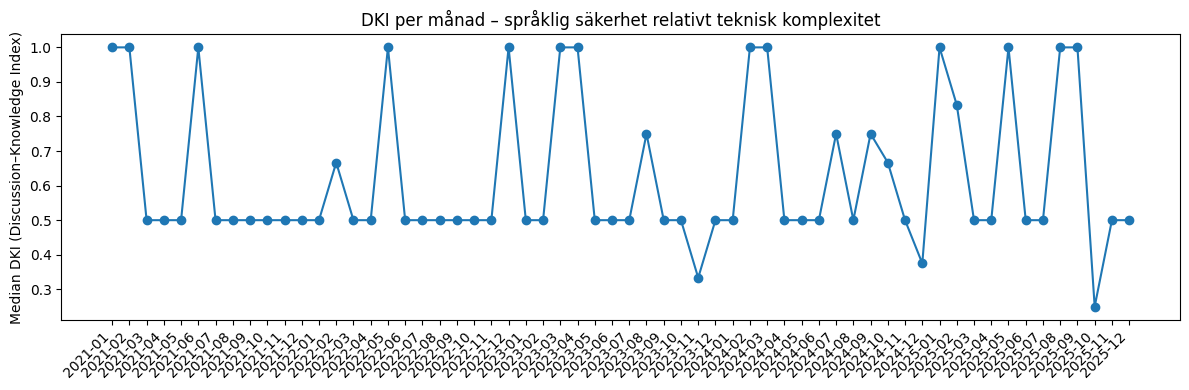

In [10]:
df["post_month"] = df["post_time"].dt.to_period("M").astype(str)

monthly_dki = (
    df.groupby("post_month")["dk_index"]
      .median()
      .sort_index()
)

plt.figure(figsize=(12,4))
plt.plot(monthly_dki.index, monthly_dki.values, marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Median DKI (Discussion–Knowledge Index)")
plt.title("DKI per månad – språklig säkerhet relativt teknisk komplexitet")
plt.tight_layout()
plt.savefig("figures_dk/dki_median_per_month.png", dpi=200)
plt.show()


In [13]:
df_topics.head()

,tid,cid,slug,topic_title,topic_timestamp,pid,post_index,post_timestamp,uid,content_html,...,username,username_norm,is_digg,post_month,content_text,content_text_norm,post_time,dk_confidence,dk_complexity,dk_index
0,282,23,282/hjälp-nosad-och-dataportalens-communityfor...,Hjälp NOSAD och dataportalens communityforum a...,2022-01-11T17:30:39.030Z,1213,0,2022-01-11T17:30:39.030Z,62,"<p dir=""auto"">11 januari hade NOSAD (Network o...",...,Maria_Dalhage,maria_dalhage,True,2022-01,11 januari hade NOSAD (Network open Source and...,11 januari hade nosad (network open source and...,2022-01-11 17:30:39.030000+00:00,0.333333,3,0.083333
1,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5304,0,2025-10-06T09:12:42.687Z,127,"<p dir=""auto"">Hej tänkte bara meddela att en f...",...,tomasmonsen,tomasmonsen,False,2025-10,Hej tänkte bara meddela att en feature som int...,hej tänkte bara meddela att en feature som int...,2025-10-06 09:12:42.687000+00:00,0.500000,2,0.166667
2,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5305,1,2025-10-06T10:06:41.301Z,1802,"<p dir=""auto"">Trevligt man kan undra varför de...",...,Magnus Sälgö,magnus sälgö,False,2025-10,Trevligt man kan undra varför detta inte beskr...,trevligt man kan undra varför detta inte beskr...,2025-10-06 10:06:41.301000+00:00,1.000000,2,0.333333
3,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5307,2,2025-10-06T12:31:26.643Z,127,"<p dir=""auto""><a class=""plugin-mentions-user p...",...,tomasmonsen,tomasmonsen,False,2025-10,@Magnus-Sälgö sa i Dataportal.se har stöd för ...,@magnus-sälgö sa i dataportal.se har stöd för ...,2025-10-06 12:31:26.643000+00:00,0.500000,2,0.166667
4,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5309,3,2025-10-06T13:16:28.870Z,1802,"<p dir=""auto"">SPARQL det är bara att vibe prog...",...,Magnus Sälgö,magnus sälgö,False,2025-10,SPARQL det är bara att vibe programmera med Ch...,sparql det är bara att vibe programmera med ch...,2025-10-06 13:16:28.870000+00:00,1.000000,2,0.333333


In [14]:
df_topics["cluster"] = kmeans.labels_

NameError: name 'kmeans' is not defined

In [11]:
from pathlib import Path
Path("figures_dk").mkdir(exist_ok=True)

# anta df_topics är subset av df med kolumn 'cluster'
df_topics = df.dropna(subset=["content_text_norm"]).copy()
# om du redan har kluster, hoppa över nästa del

# om df_topics redan har cluster från din tidigare SVD+KMeans:
# df_topics = df_topics_with_cluster

cluster_dki = (
    df_topics.groupby("cluster")["dk_index"]
    .median()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,4))
cluster_dki.plot(kind="bar")
plt.ylabel("Median DKI")
plt.title("DKI per kluster (ämnesgrupp)")
plt.tight_layout()
plt.savefig("figures_dk/dki_per_cluster.png", dpi=200)
plt.show()


KeyError: 'cluster'

In [3]:
 # End timer and calculate duration
end_time = time.time()
elapsed_time = end_time - start_time# Bygg audit-lager för den här etappen

# Print current date and total time
print("Date:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
minutes, seconds = divmod(elapsed_time, 60)
print("Total time elapsed: {:02.0f} minutes {:05.2f} seconds".format(minutes, seconds))


Date: 2025-12-05 05:35:22
Total time elapsed: 04 minutes 55.69 seconds
